In [41]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, random

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

import functools

import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
# from jaxns import analytic_log_evidence
from jaxns import Prior, Model


In [42]:
def get_kernel(kernel_type, kernel_params):
    """
    Function for producing the kernel for the Gaussian Process.
    Returns the selected Tinygp kernel

    Parameters
    ----------
    kernel_type: string
        The type of kernel to be used for the Gaussian Process
        To be selected from the kernels already implemented

    kernel_params: dict
        Dictionary containing the parameters for the kernel
        Should contain the parameters for the selected kernel

    """
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        ) + kernels.quasisep.Celerite(
            a=kernel_params["aqpo"],
            b=0.0,
            c=kernel_params["cqpo"],
            d=2 * jnp.pi * kernel_params["freq"],
        )
        return kernel
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
            scale=1 / kernel_params["crn"], sigma=(kernel_params["arn"]) ** 0.5
        )
        return kernel


def get_mean(mean_type, mean_params):
    """
    Function for producing the mean for the Gaussian Process.

    Parameters
    ----------
    mean_type: string
        The type of mean to be used for the Gaussian Process
        To be selected from the mean functions already implemented

    mean_params: dict
        Dictionary containing the parameters for the mean
        Should contain the parameters for the selected mean

    """
    if mean_type == "gaussian":
        mean = functools.partial(_gaussian, mean_params=mean_params)
    elif mean_type == "exponential":
        mean = functools.partial(_exponential, mean_params=mean_params)
    elif mean_type == "constant":
        mean = functools.partial(_constant, mean_params=mean_params)
    elif mean_type == "skew_gaussian":
        mean = functools.partial(_skew_gaussian, mean_params=mean_params)
    elif mean_type == "skew_exponential":
        mean = functools.partial(_skew_exponential, mean_params=mean_params)
    elif mean_type == "fred":
        mean = functools.partial(_fred, mean_params=mean_params)
    return mean


def _gaussian(t, mean_params):
    """A gaussian flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the gaussian.

    Returns
    -------
    The y values for the gaussian flare.
    """
    # Send this to the get_mean function
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    # print((jnp.sum (A * jnp.exp(
    #     -((t - t0) ** 2) / (2 * (sig ** 2))
    # )
    # , axis=0)).shape )

    return jnp.sum (A * jnp.exp(
        -((t - t0) ** 2) / (2 * (sig ** 2))
    )
    , axis=0)


def _exponential(t, mean_params):
    """An exponential flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the exponential.

    Returns
    -------
    The y values for exponential flare.
    """
    # return mean_params["A"] * jnp.exp(-jnp.abs((t - mean_params["t0"])) / mean_params["sig"])
    A = jnp.atleast_1d(mean_params["A"])[:,jnp.newaxis]
    t0 = jnp.atleast_1d(mean_params["t0"])[:,jnp.newaxis]
    sig = jnp.atleast_1d(mean_params["sig"])[:,jnp.newaxis]

    return jnp.sum (A * jnp.exp(
        -jnp.abs(t - t0) / (2 * (sig ** 2))
    )
    , axis=0)


def _constant(t, mean_params):
    """A constant mean shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Constant amplitude of the flare.

    Returns
    -------
    The constant value.
    """
    return mean_params["A"] * jnp.ones_like(t)


def _skew_gaussian(t, mean_params):
    """A skew gaussian flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the rising edge.
    sig2:
        The width parameter for the falling edge.

    Returns
    -------
    The y values for skew gaussian flare.
    """
    return mean_params["A"] * jnp.where(
        t > mean_params["t0"],
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig2"] ** 2))),
        jnp.exp(-((t - mean_params["t0"]) ** 2) / (2 * (mean_params["sig1"] ** 2))),
    )


def _skew_exponential(t, mean_params):
    """A skew exponential flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    sig1:
        The width parameter for the rising edge.
    sig2:
        The width parameter for the falling edge.

    Returns
    -------
    The y values for exponential flare.
    """
    return mean_params["A"] * jnp.where(
        t > mean_params["t0"],
        jnp.exp(-(t - mean_params["t0"]) / mean_params["sig2"]),
        jnp.exp((t - mean_params["t0"]) / mean_params["sig1"]),
    )

def _fred(t, mean_params):
    """A fast rise exponential decay (FRED) flare shape.

    Parameters
    ----------
    t:  jnp.ndarray
        The time coordinates.
    A:  jnp.int
        Amplitude of the flare.
    t0:
        The location of the maximum.
    phi:
        Symmetry parameter of the flare.
    delta:
        Offset parameter of the flare.

    Returns
    -------
    The y values for exponential flare.
    """
    return mean_params["A"] * jnp.exp(-mean_params["phi"] * ((t + mean_params["delta"])/mean_params["t0"] + 
                                                             mean_params["t0"]/(t + mean_params["delta"])))*jnp.exp(2*mean_params["phi"])


In [43]:
2*jnp.exp(-2)

Array(0.27067057, dtype=float64, weak_type=True)

In [59]:
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

def get_prior(kernel_type, mean_type, **kwargs):
    """
    A prior generator function based on given values

    Parameters
    ----------
    kwargs:
        All possible keyword arguments to construct the prior.

    Returns
    -------
    The Prior function.
    The arguments of the prior function are in the order of
    Kernel arguments (RN arguments, QPO arguments),
    Mean arguments
    Non Windowed arguments

    """
    kwargs["T"] = kwargs["Times"][-1] - kwargs["Times"][0]  # Total time
    kwargs["f"] = 1 / (kwargs["Times"][1] - kwargs["Times"][0])  # Sampling frequency
    kwargs["min"] = jnp.min(kwargs["counts"])
    kwargs["max"] = jnp.max(kwargs["counts"])
    kwargs["span"] = kwargs["max"] - kwargs["min"]

    def RNprior_model():
        arn = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="arn")
        crn = yield Prior(tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])), name="crn")

        A = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="A")
        t0 = yield Prior(
            tfpd.Uniform(
                kwargs["Times"][0] - 0.1 * kwargs["T"], kwargs["Times"][-1] + 0.1 * kwargs["T"]
            ),
            name="t0",
        )
        sig = yield Prior(tfpd.Uniform(0.5 * 1 / kwargs["f"], 2 * kwargs["T"]), name="sig")
        return arn, crn, A, t0, sig

    if (kernel_type == "RN") & ((mean_type == "gaussian") | (mean_type == "exponential")):
        return RNprior_model

    def QPOprior_model():
        arn = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="arn")
        crn = yield Prior(tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])), name="crn")
        aqpo = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="aqpo")
        cqpo = yield Prior(tfpd.Uniform(1 / 10 / kwargs["T"], jnp.log(kwargs["f"])), name="cqpo")
        freq = yield Prior(tfpd.Uniform(2 / kwargs["T"], kwargs["f"] / 2), name="freq")

        # A = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="A")
        A = yield Prior(tfpd.Uniform(low=0.1 * kwargs["span"] * jnp.ones(kwargs["n"]), high=2 * kwargs["span"] * jnp.ones(kwargs["n"])), name='A')
        t0 = []
        scale_bij = tfp.bijectors.Scale(scale=kwargs["Times"][-1]+0.1*kwargs["T"] - kwargs["Times"][0]-0.1*kwargs["T"])
        shift_bij = tfp.bijectors.Shift(shift=kwargs["Times"][0]-0.1*kwargs["T"])
        for i in range(kwargs["n"]):
            underlying_beta = tfpd.Beta(
                concentration0=jnp.asarray(1., float_type),
                concentration1=jnp.asarray(kwargs["n"] - i, float_type)
            )
            t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
            # Update the shift and scale here
            scale_bij = tfp.bijectors.Scale(scale=kwargs["Times"][-1]+0.1*kwargs["T"] - t)
            shift_bij = tfp.bijectors.Shift(shift=t)
            t0.append(t)
        t0 = jnp.stack(t0)
        sig = yield Prior(tfpd.Uniform(0.5 * 1 / kwargs["f"], 2 * kwargs["T"]), name="sig")

        return arn, crn, aqpo, cqpo, freq, A, t0, sig

    if (kernel_type == "QPO_plus_RN") & ((mean_type == "gaussian") | (mean_type == "exponential")):
        return QPOprior_model

    def skew_RNprior_model():
        arn = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="arn")
        crn = yield Prior(tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])), name="crn")

        A = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="A")
        t0 = yield Prior(
            tfpd.Uniform(
                kwargs["Times"][0] - 0.1 * kwargs["T"], kwargs["Times"][-1] + 0.1 * kwargs["T"]
            ),
            name="t0",
        )
        sig1 = yield Prior(tfpd.Uniform(0.5 * 1 / kwargs["f"], 2 * kwargs["T"]), name="sig1")
        sig2 = yield Prior(tfpd.Uniform(0.5 * 1 / kwargs["f"], 2 * kwargs["T"]), name="sig2")

        return arn, crn, A, t0, sig1, sig2

    if (kernel_type == "RN") & ((mean_type == "skew_gaussian") | (mean_type == "skew_exponential")):
        return skew_RNprior_model

    def skew_QPOprior_model():
        arn = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="arn")
        crn = yield Prior(tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])), name="crn")
        aqpo = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="aqpo")
        cqpo = yield Prior(tfpd.Uniform(1 / 10 / kwargs["T"], jnp.log(kwargs["f"])), name="cqpo")
        freq = yield Prior(tfpd.Uniform(2 / kwargs["T"], kwargs["f"] / 2), name="freq")

        A = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="A")
        t0 = yield Prior(
            tfpd.Uniform(
                kwargs["Times"][0] - 0.1 * kwargs["T"], kwargs["Times"][-1] + 0.1 * kwargs["T"]
            ),
            name="t0",
        )
        sig1 = yield Prior(tfpd.Uniform(0.5 * 1 / kwargs["f"], 2 * kwargs["T"]), name="sig1")
        sig2 = yield Prior(tfpd.Uniform(0.5 * 1 / kwargs["f"], 2 * kwargs["T"]), name="sig2")

        return arn, crn, aqpo, cqpo, freq, A, t0, sig1, sig2

    if (kernel_type == "QPO_plus_RN") & (
        (mean_type == "skew_gaussian") | (mean_type == "skew_exponential")
    ):
        return skew_QPOprior_model
    
    def fred_RNprior_model():
        arn = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="arn")
        crn = yield Prior(tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])), name="crn")

        A = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="A")
        t0 = yield Prior(
            tfpd.Uniform(
                kwargs["Times"][0] - 0.1 * kwargs["T"], kwargs["Times"][-1] + 0.1 * kwargs["T"]
            ),
            name="t0",
        )
        phi = yield Prior(tfpd.Uniform(2*jnp.exp(-2), 2*jnp.exp(4)), name="phi")
        delta = yield Prior(tfpd.Uniform(0, kwargs["Times"][-1]/2), name="delta")

        return arn, crn, A, t0, phi, delta

    if (kernel_type == "RN") & (mean_type == "fred"):
        return fred_RNprior_model

    def fred_QPOprior_model():
        arn = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="arn")
        crn = yield Prior(tfpd.Uniform(jnp.log(1 / kwargs["T"]), jnp.log(kwargs["f"])), name="crn")
        aqpo = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="aqpo")
        cqpo = yield Prior(tfpd.Uniform(1 / 10 / kwargs["T"], jnp.log(kwargs["f"])), name="cqpo")
        freq = yield Prior(tfpd.Uniform(2 / kwargs["T"], kwargs["f"] / 2), name="freq")

        A = yield Prior(tfpd.Uniform(0.1 * kwargs["span"], 2 * kwargs["span"]), name="A")
        t0 = yield Prior(
            tfpd.Uniform(
                kwargs["Times"][0] - 0.1 * kwargs["T"], kwargs["Times"][-1] + 0.1 * kwargs["T"]
            ),
            name="t0",
        )
        phi = yield Prior(tfpd.Uniform(2*jnp.exp(-2), 2*jnp.exp(4)), name="phi")
        delta = yield Prior(tfpd.Uniform(0, kwargs["Times"][-1]/2), name="delta")

        return arn, crn, aqpo, cqpo, freq, A, t0, phi, delta

    if (kernel_type == "QPO_plus_RN") & (mean_type == "fred"):
        return fred_QPOprior_model



def get_likelihood(kernel_type, mean_type, **kwargs):
    """
    A likelihood generator function based on given values
    """

    @jit
    def RNlog_likelihood(arn, crn, A, t0, sig):
        rnlikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": 0.0,
            "cqpo": 0.0,
            "freq": 0.0,
        }

        mean_params = {
            "A": A,
            "t0": t0,
            "sig": sig,
        }

        kernel = get_kernel(kernel_type="RN", kernel_params=rnlikelihood_params)

        mean = get_mean(mean_type=mean_type, mean_params=mean_params)

        # gp = GaussianProcess(kernel, kwargs["Times"], mean=mean)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    if (kernel_type == "RN") & ((mean_type == "gaussian") | (mean_type == "exponential")):
        return RNlog_likelihood

    @jit
    def QPOlog_likelihood(arn, crn, aqpo, cqpo, freq, A, t0, sig):
        qpolikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": aqpo,
            "cqpo": cqpo,
            "freq": freq,
        }

        mean_params = {
            "A": A,
            "t0": t0,
            "sig": sig,
        }

        kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=qpolikelihood_params)
        mean = get_mean(mean_type=mean_type, mean_params=mean_params)

        # gp = GaussianProcess(kernel, kwargs["Times"], mean=mean)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    if (kernel_type == "QPO_plus_RN") & ((mean_type == "gaussian") | (mean_type == "exponential")):
        return QPOlog_likelihood

    @jit
    def skew_RNlog_likelihood(arn, crn, A, t0, sig1, sig2):
        rnlikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": 0.0,
            "cqpo": 0.0,
            "freq": 0.0,
        }

        mean_params = {
            "A": A,
            "t0": t0,
            "sig1": sig1,
            "sig2": sig2,
        }

        kernel = get_kernel(kernel_type="RN", kernel_params=rnlikelihood_params)

        # This could be causing problems
        mean = get_mean(mean_type=mean_type, mean_params=mean_params)

        # gp = GaussianProcess(kernel, kwargs["Times"], mean=mean)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    if (kernel_type == "RN") & ((mean_type == "gaussian") | (mean_type == "exponential")):
        return skew_RNlog_likelihood

    @jit
    def skewQPOlog_likelihood(arn, crn, aqpo, cqpo, freq, A, t0, sig1, sig2):
        qpolikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": aqpo,
            "cqpo": cqpo,
            "freq": freq,
        }

        mean_params = {
            "A": A,
            "t0": t0,
            "sig1": sig1,
            "sig2": sig2,
        }

        kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=qpolikelihood_params)

        mean = get_mean(mean_type=mean_type, mean_params=mean_params)

        # gp = GaussianProcess(kernel, kwargs["Times"], mean=mean)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    if (kernel_type == "QPO_plus_RN") & (
        (mean_type == "skew_gaussian") | (mean_type == "skew_exponential")
    ):
        return skewQPOlog_likelihood
    
    @jit
    def fred_RNlog_likelihood(arn, crn, A, t0,  phi, delta):
        rnlikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": 0.0,
            "cqpo": 0.0,
            "freq": 0.0,
        }

        mean_params = {
            "A": A,
            "t0": t0,
            "phi": phi,
            "delta": delta,
        }

        kernel = get_kernel(kernel_type="RN", kernel_params=rnlikelihood_params)

        # This could be causing problems
        mean = get_mean(mean_type=mean_type, mean_params=mean_params)

        # gp = GaussianProcess(kernel, kwargs["Times"], mean=mean)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    if (kernel_type == "RN") & (mean_type == "fred"):
        return fred_RNlog_likelihood

    @jit
    def fredQPOlog_likelihood(arn, crn, aqpo, cqpo, freq, A, t0, phi, delta):
        qpolikelihood_params = {
            "arn": arn,
            "crn": crn,
            "aqpo": aqpo,
            "cqpo": cqpo,
            "freq": freq,
        }

        mean_params = {
            "A": A,
            "t0": t0,
            "phi": phi,
            "delta": delta,
        }

        kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=qpolikelihood_params)

        mean = get_mean(mean_type=mean_type, mean_params=mean_params)

        # gp = GaussianProcess(kernel, kwargs["Times"], mean=mean)
        gp = GaussianProcess(kernel, kwargs["Times"], mean_value=mean(kwargs["Times"]))
        return gp.log_probability(kwargs["counts"])

    if (kernel_type == "QPO_plus_RN") & (mean_type == "fred"):
        return fredQPOlog_likelihood

class GP:
    """
    Makes a GP object which takes in a Stingray.Lightcurve and fits a Gaussian
    Process on the lightcurve data, for the given kernel.

    Parameters
    ----------
    lc: Stingray.Lightcurve object
        The lightcurve on which the gaussian process, is to be fitted

    Model_type: string tuple
        Has two strings with the first being the name of the kernel type
        and the secound being the mean type

    Model_parameter: dict, default = None
        Dictionary conatining the parameters for the mean and kernel
        The keys should be accourding to the selected kernel and mean
        coressponding to the Model_type
        By default, it takes a value None, and the kernel and mean are
        then bulit using the pre-set parameters.

    Other Parameters
    ----------------
    kernel: class: `TinyGp.kernel` object
        The tinygp kernel for the GP

    mean: class: `TinyGp.mean` object
        The tinygp mean for the GP

    maingp: class: `TinyGp.GaussianProcess` object
        The tinygp gaussian process made on the lightcurve

    """
    def __init__(self, Lc: Lightcurve) -> None:
        self.lc = Lc
        self.time = Lc.time
        self.counts = Lc.counts
    
    def fit(self, kernel = None, mean = None, **kwargs):
        self.kernel = kernel
        self.mean = mean
        self.maingp = GaussianProcess(
            self.kernel, self.time, mean_value =self.mean(self.time), diag=kwargs["diag"]
        )
    
    def get_logprob(self):
        """
        Returns the logprobability of the lightcurves counts for the
        given kernel for the Gaussian Process
        """
        cond = self.maingp.condition(self.lc.counts)
        return cond.log_probability
    
    def plot_kernel(self):
        """
        Plots the kernel of the Gaussian Process
        """
        X = self.lc.time
        Y = self.kernel(X, np.array([0.0]))
        plt.plot(X, Y)
        plt.xlabel("distance")
        plt.ylabel("Value")
        plt.title("Kernel Function")

    def plot_originalgp(self, sample_no=1, seed=0):
        """
        Plots samples obtained from the gaussian process for the kernel

        Parameters
        ----------
        sample_no: int , default = 1
            Number of GP samples to be taken

        """
        X_test = self.lc.time
        _, ax = plt.subplots(1, 1, figsize=(10, 3))
        y_samp = self.maingp.sample(jax.random.PRNGKey(seed), shape=(sample_no,))
        ax.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
        ax.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)
        ax.set_xlabel("time")
        ax.set_ylabel("counts")
        ax.legend(loc="best")

    def plot_gp(self, sample_no=1, seed=0):
        """
        Plots gaussian process, conditioned on the lightcurve
        Also, plots the lightcurve along with it

        Parameters
        ----------
        sample_no: int , default = 1
            Number of GP samples to be taken

        """
        X_test = self.lc.time

        _, ax = plt.subplots(1, 1, figsize=(10, 3))
        _, cond_gp = self.maingp.condition(self.lc.counts, X_test)
        mu = cond_gp.mean
        # std = np.sqrt(cond_gp.variance)

        ax.plot(self.lc.time, self.lc.counts, lw=2, color="blue", label="Lightcurve")
        ax.plot(X_test, mu, "C1", label="Gaussian Process")
        y_samp = cond_gp.sample(jax.random.PRNGKey(seed), shape=(sample_no,))
        ax.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5)
        ax.set_xlabel("time")
        ax.set_ylabel("counts")
        ax.legend(loc="best")
    
    def sample(self, prior_model = None, likelihood_model = None, **kwargs):
        """
        Runs a sampling process for the hyperparameters for the GP model.
        Based on No U turn Sampling from the numpyro module
        """

        # dict = {"Times": self.lc.time, "counts": self.lc.counts, "n": self.prior_parameters["n"]}
        # self.prior_model = get_prior(self.prior_type[0], self.prior_type[1], **dict)
        # self.likelihood = get_likelihood(self.prior_type[0], self.prior_type[1], **dict)
        self.prior_model = prior_model
        self.likelihood_model = likelihood_model

        NSmodel = Model(prior_model=self.prior_model, log_likelihood=self.likelihood_model)
        NSmodel.sanity_check(random.PRNGKey(10), S=100)

        self.Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
        Termination_reason, State = self.Exact_ns(
            random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
        )
        self.Results = self.Exact_ns.to_results(State, Termination_reason)
        print("Simulation Complete")
    
    def print_summary(self):
        """
        Prints a summary table for the model parameters
        """
        self.Exact_ns.summary(self.Results)

    def plot_diagnostics(self):
        """
        Plots the diagnostic plots for the sampling process
        """
        self.Exact_ns.plot_diagnostics(self.Results)

    def plot_cornerplot(self):
        """
        Plots the corner plot for the sampled hyperparameters
        """
        self.Exact_ns.plot_cornerplot(self.Results)

    def get_parameters(self):
        """
        Returns the optimal parameters for the model based on the NUTS sampling
        """

        pass

    def plot_posterior(self, X_test):
        """
        Plots posterior gaussian process, conditioned on the lightcurve
        Also, plots the lightcurve along with it

        Parameters
        ----------
        X_test: jnp.array
            Array over which the Gaussian process values are to be obtained
            Can be made default with lc.times as default

        """

        pass



# class GP:
#     """
#     Makes a GP object which takes in a Stingray.Lightcurve and fits a Gaussian
#     Process on the lightcurve data, for the given kernel.

#     Parameters
#     ----------
#     lc: Stingray.Lightcurve object
#         The lightcurve on which the gaussian process, is to be fitted

#     Model_type: string tuple
#         Has two strings with the first being the name of the kernel type
#         and the secound being the mean type

#     Model_parameter: dict, default = None
#         Dictionary conatining the parameters for the mean and kernel
#         The keys should be accourding to the selected kernel and mean
#         coressponding to the Model_type
#         By default, it takes a value None, and the kernel and mean are
#         then bulit using the pre-set parameters.

#     Other Parameters
#     ----------------
#     kernel: class: `TinyGp.kernel` object
#         The tinygp kernel for the GP

#     mean: class: `TinyGp.mean` object
#         The tinygp mean for the GP

#     maingp: class: `TinyGp.GaussianProcess` object
#         The tinygp gaussian process made on the lightcurve

#     """

#     def __init__(self, Lc: Lightcurve, Model_type: tuple, Model_params: dict = None) -> None:
#         self.lc = Lc
#         self.Model_type = Model_type
#         self.Model_param = Model_params
#         self.kernel = get_kernel(self.Model_type[0], self.Model_param)
#         self.mean = get_mean(self.Model_type[1], self.Model_param)
#         print("ndim: ",self.mean(Lc.time).ndim)
#         self.maingp = GaussianProcess(
#             self.kernel, Lc.time, mean_value =self.mean(Lc.time), diag=Model_params["diag"]
#         )

#     def get_logprob(self):
#         """
#         Returns the logprobability of the lightcurves counts for the
#         given kernel for the Gaussian Process
#         """
#         cond = self.maingp.condition(self.lc.counts)
#         return cond.log_probability

#     def get_model(self):
#         """
#         Returns the model of the Gaussian Process
#         """
#         return (self.Model_type, self.Model_param)

#     def plot_kernel(self):
#         """
#         Plots the kernel of the Gaussian Process
#         """
#         X = self.lc.time
#         Y = self.kernel(X, np.array([0.0]))
#         plt.plot(X, Y)
#         plt.xlabel("distance")
#         plt.ylabel("Value")
#         plt.title("Kernel Function")

#     def plot_originalgp(self, sample_no=1, seed=0):
#         """
#         Plots samples obtained from the gaussian process for the kernel

#         Parameters
#         ----------
#         sample_no: int , default = 1
#             Number of GP samples to be taken

#         """
#         X_test = self.lc.time
#         _, ax = plt.subplots(1, 1, figsize=(10, 3))
#         y_samp = self.maingp.sample(jax.random.PRNGKey(seed), shape=(sample_no,))
#         ax.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
#         ax.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)
#         ax.set_xlabel("time")
#         ax.set_ylabel("counts")
#         ax.legend(loc="best")

#     def plot_gp(self, sample_no=1, seed=0):
#         """
#         Plots gaussian process, conditioned on the lightcurve
#         Also, plots the lightcurve along with it

#         Parameters
#         ----------
#         sample_no: int , default = 1
#             Number of GP samples to be taken

#         """
#         X_test = self.lc.time

#         _, ax = plt.subplots(1, 1, figsize=(10, 3))
#         _, cond_gp = self.maingp.condition(self.lc.counts, X_test)
#         mu = cond_gp.mean
#         # std = np.sqrt(cond_gp.variance)

#         ax.plot(self.lc.time, self.lc.counts, lw=2, color="blue", label="Lightcurve")
#         ax.plot(X_test, mu, "C1", label="Gaussian Process")
#         y_samp = cond_gp.sample(jax.random.PRNGKey(seed), shape=(sample_no,))
#         ax.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5)
#         ax.set_xlabel("time")
#         ax.set_ylabel("counts")
#         ax.legend(loc="best")

# class GPResult:
#     """
#     Makes a GP regressor for a given GP class and a prior over it.
#     Provides the sampled hyperparameters and tabulates their charachtersistics
#     Using jaxns for nested sampling and evidence analysis

#     Parameters
#     ----------
#     GP: class: GP
#         The initial GP class, on which we will apply our regressor.

#     prior_type: string tuple
#         Has two strings with the first being the name of the kernel type
#         and the secound being the mean type for the prior

#     prior_parameters: dict, default = None
#         Dictionary containing the parameters for the mean and kernel priors
#         The keys should be accourding to the selected kernel and mean
#         prior coressponding to the prior_type
#         By default, it takes a value None, and the kernel and mean priors are
#         then bulit using the pre-set parameters.

#     Other Parameters
#     ----------------
#     lc: Stingray.Lightcurve object
#         The lightcurve on which the gaussian process regression, is to be done

#     """

#     def __init__(self, GP: GP, prior_type: tuple, prior_parameters=None) -> None:
#         self.gpclass = GP
#         self.prior_type = prior_type
#         self.prior_parameters = prior_parameters
#         self.lc = GP.lc

#     def run_sampling(self):
#         """
#         Runs a sampling process for the hyperparameters for the GP model.
#         Based on No U turn Sampling from the numpyro module
#         """

#         dict = {"Times": self.lc.time, "counts": self.lc.counts, "n": self.prior_parameters["n"]}
#         self.prior_model = get_prior(self.prior_type[0], self.prior_type[1], **dict)
#         self.likelihood = get_likelihood(self.prior_type[0], self.prior_type[1], **dict)

#         NSmodel = Model(prior_model=self.prior_model, log_likelihood=self.likelihood)

#         NSmodel.sanity_check(random.PRNGKey(10), S=100)

#         self.Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
#         Termination_reason, State = self.Exact_ns(
#             random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
#         )
#         self.Results = self.Exact_ns.to_results(State, Termination_reason)
#         print("Simulation Complete")

#     def print_summary(self):
#         """
#         Prints a summary table for the model parameters
#         """
#         self.Exact_ns.summary(self.Results)

#     def plot_diagnostics(self):
#         """
#         Plots the diagnostic plots for the sampling process
#         """
#         self.Exact_ns.plot_diagnostics(self.Results)

#     def plot_cornerplot(self):
#         """
#         Plots the corner plot for the sampled hyperparameters
#         """
#         self.Exact_ns.plot_cornerplot(self.Results)

#     def get_parameters(self):
#         """
#         Returns the optimal parameters for the model based on the NUTS sampling
#         """

#         pass

#     def plot_posterior(self, X_test):
#         """
#         Plots posterior gaussian process, conditioned on the lightcurve
#         Also, plots the lightcurve along with it

#         Parameters
#         ----------
#         X_test: jnp.array
#             Array over which the Gaussian process values are to be obtained
#             Can be made default with lc.times as default

#         """

#         pass



NOW IS THE TESTING CODE

1
(256, 1)


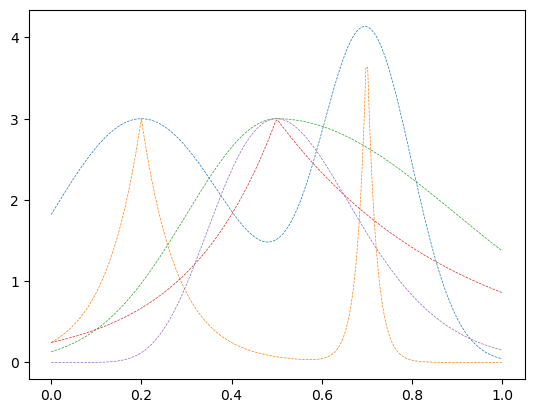

In [60]:
Times = np.linspace(0,1,256)

gaussian_mean = get_mean(mean_type = "gaussian", 
                    # mean_params = {"A" : 3, "t0" : 0.5, "sig" : 0.2})
                    mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig" : jnp.array([0.2, 0.1]) })

exponential_mean = get_mean(mean_type = "exponential",
                    # mean_params = {"A" : 3, "t0" : 0.5, "sig" : 0.2})
                    mean_params = {"A" : (3.0, 4.0), "t0" : jnp.array([0.2, 0.7]), "sig" : jnp.array([0.2, 0.1]) })

skew_gaussian_mean= get_mean(mean_type = "skew_gaussian",
                             mean_params = {"A" : 3,    "t0" : 0.5,    "sig1" : 0.2,    "sig2" : 0.4})
# skew_gaussian_mean2= get_mean(mean_type = "skew_gaussian",
#                              mean_params = {"A" : 3, "t0" : jnp.array([0.2, 0.7]), "sig1" : jnp.array([0.2,0.3]), "sig2" : jnp.array([0.2,0.1]) })
skew_exp_mean= get_mean(mean_type = "skew_exponential",
                             mean_params = {"A" : 3,    "t0" : 0.5,    "sig1" : 0.2,    "sig2" : 0.4})

fred_mean = get_mean(mean_type = "fred",
                                mean_params = {"A" : 3,    "t0" : 0.7,    "phi" : 10,    "delta" : 0.2})

plt.plot(Times, gaussian_mean(Times), lw=0.5, ls = "--", label = "gaussian")
plt.plot(Times, exponential_mean(Times), lw=0.5, ls = "--", label = "exponential")
plt.plot(Times, skew_gaussian_mean(Times), lw=0.5, ls = "--", label = "skew_gaussian")
# plt.plot(Times, skew_gaussian_mean2(Times), lw=0.5, ls = "--", label = "skew_gaussian2")
plt.plot(Times, skew_exp_mean(Times), lw=0.5, ls = "--", label = "skew_exp")
plt.plot(Times, fred_mean(Times), lw=0.5, ls = "--", label = "fred")

print(gaussian_mean(Times).ndim)
print((jax.vmap(gaussian_mean)(Times)).shape)
# Also try multi-mean model

In [64]:
import tinygp

# MAKING THE DATA
Times = np.linspace(0,1,256)

kernel = kernel = kernels.quasisep.Exp(
                scale = 1/jnp.exp(1.0), sigma = (jnp.exp(1.0))**0.5) + kernels.quasisep.Celerite(
                a = jnp.exp(-2), b = 0.0, c = jnp.exp(1), d = 2*jnp.pi*20)

def gaussian(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

# mean = functools.partial(gaussian, mean_params = {"A" : 3,    "t0" : 0.5,    "sig" : 0.2})
# mean = get_mean(mean_type = "skew_gaussian", mean_params = {"A" : 3,    "t0" : 0.5,    "sig1" : 0.2,    "sig2" : 0.4})
mean = get_mean(mean_type = "gaussian", 
                    # mean_params = {"A" : 3, "t0" : 0.5, "sig" : 0.2})
                    mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), "sig" : jnp.array([0.2, 0.1]) })

# mean = get_mean(mean_type = "fred",
#                 mean_params = {"A" : 3,    "t0" : 0.7,    "phi" : 10,    "delta" : 0.2})

hqpogp = tinygp.GaussianProcess( kernel, Times, mean_value = mean(Times) , diag = 0.01)

counts = hqpogp.sample(jax.random.PRNGKey(101))
lightcurve = Lightcurve(Times, counts)

# MAKING THE GP

parameters = {
                "Times" : Times, "counts" : counts, "diag" : 0.01, 
                "arn" : jnp.exp(1.0), "crn" : jnp.exp(1.0),
                "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),   "freq": 20,
                # "A" : 3,    "t0" : 0.5,    "sig1" : 0.2,    "sig2" : 0.4,
                "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
                "n" : 2,
}

# from GP import GP

model_type = ("QPO_plus_RN", "gaussian")

# gp = GP(Lc = lightcurve, Model_type = model_type, Model_params = parameters)
gp = GP(Lc = lightcurve)

dict = {"Times": Times, "counts": counts, "n": 3}
prior_model = get_prior("QPO_plus_RN", "gaussian", **dict)
print(prior_model)
likelihood_model = get_likelihood("QPO_plus_RN", "gaussian", **dict)
print(likelihood_model)
gp.sample(prior_model = prior_model, likelihood_model= likelihood_model)


INFO[2023-06-20 22:20:09,716]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-06-20 22:20:09,717]: Checking if light curve is sorted.
INFO[2023-06-20 22:20:09,717]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<function get_prior.<locals>.QPOprior_model at 0x32453adc0>
<PjitFunction of <function get_likelihood.<locals>.QPOlog_likelihood at 0x32453a8b0>>


INFO[2023-06-20 22:20:12,428]: Sanity check...
INFO[2023-06-20 22:20:12,612]: Sanity check passed


Simulation Complete


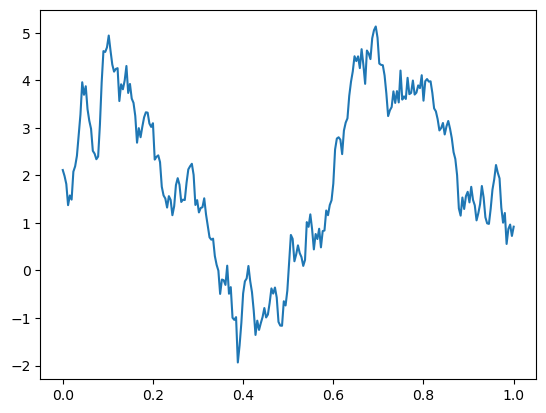

In [65]:
plt.plot(Times, counts)

WARNING[2023-06-20 22:22:42,122]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


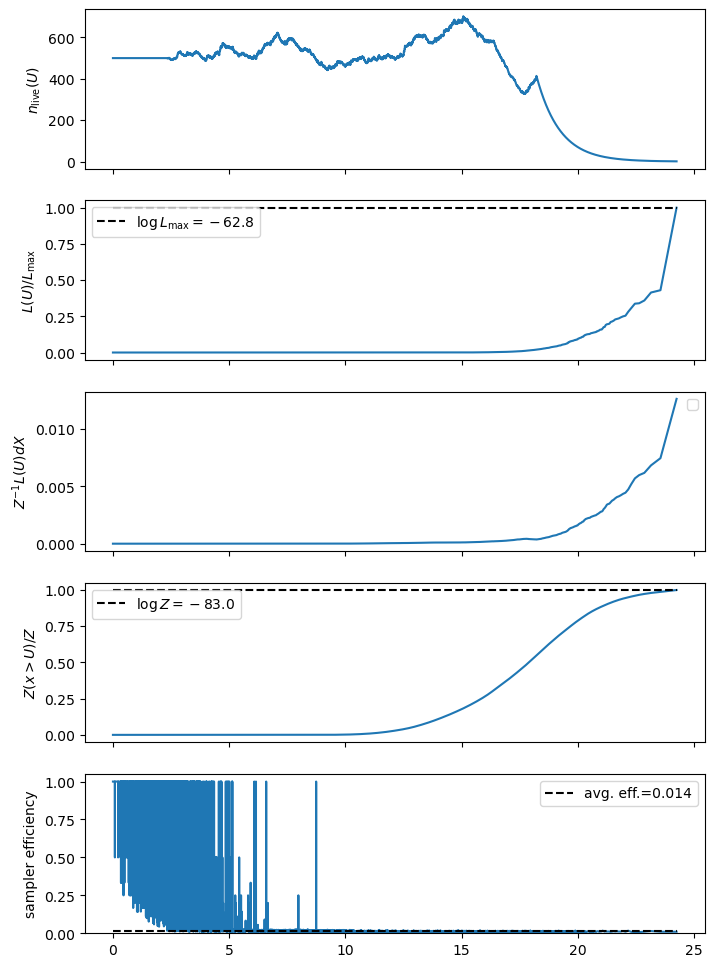

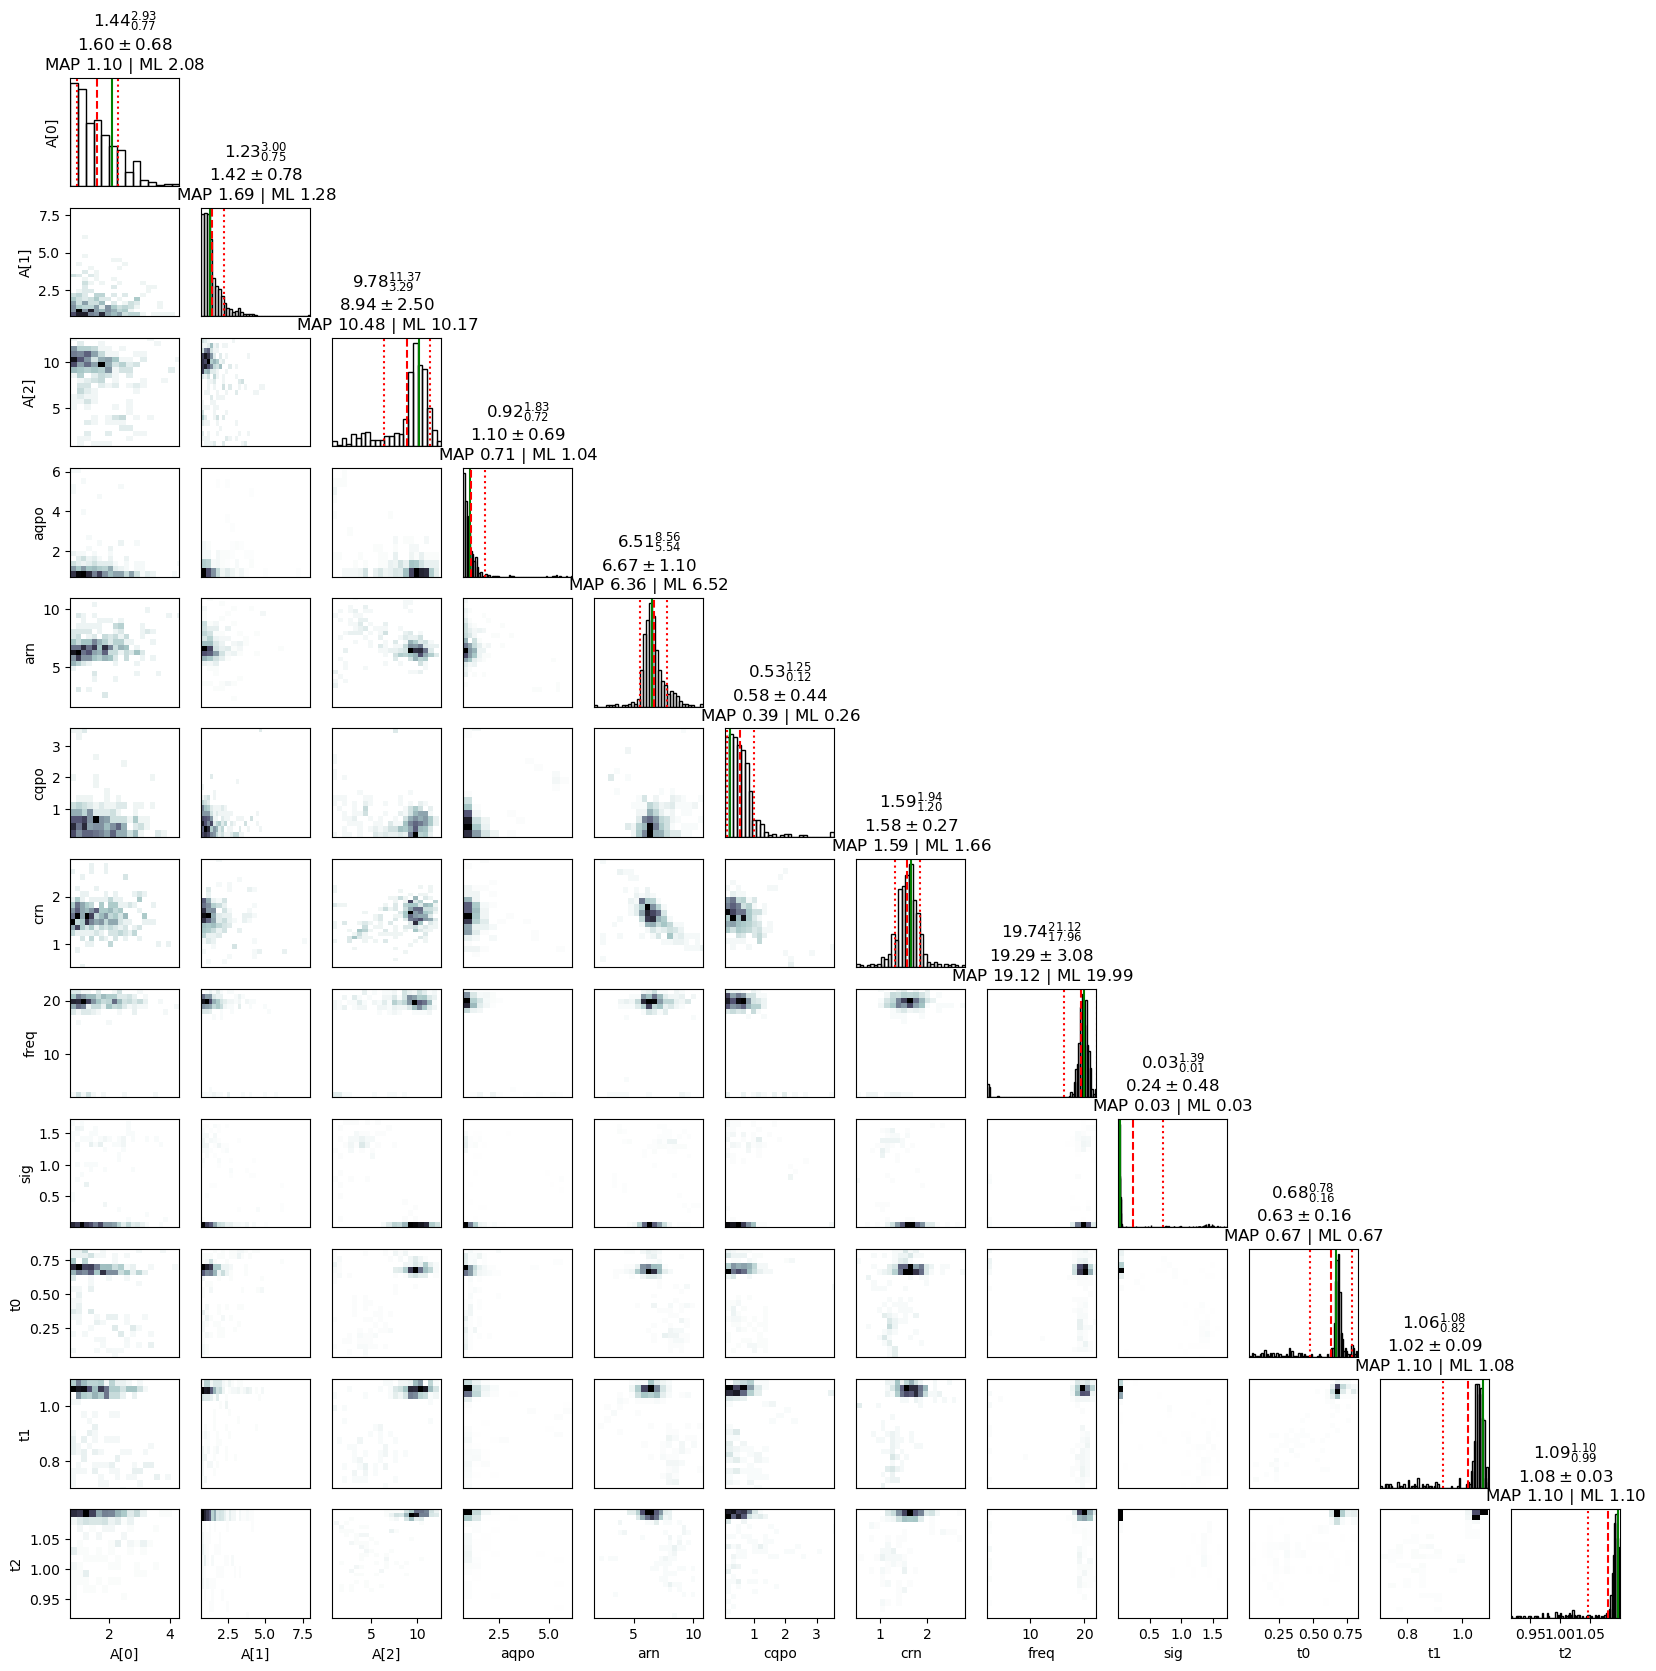

In [66]:
gp.plot_diagnostics()
gp.plot_cornerplot()